In [1]:
import sys
import os
import pandas as pd
current_path = os.getcwd()
parent_dir = os.path.join(current_path, "..")
print("Current working directory:", current_path)
print("Path to the parent directory:",parent_dir)
sys.path.append(parent_dir)
import simulator as sm
import numpy as np
import astropy.units as U
from casatasks import exportfits, simobserve, tclean, gaincal, applycal
from casatools import table
from casatools import simulator as casa_simulator
import random
import shutil
from astropy.constants import c
import math
import matplotlib.pyplot as plt

Current working directory: /home/astro/Documents/GitHub/ALMASim/experimental
Path to the parent directory: /home/astro/Documents/GitHub/ALMASim/experimental/..


In [ ]:
metadata = sm.query_for_metadata_by_science_type(os.path.join(parent_dir, 'metadata', 'Active_galaxies_metadata.csv'))

In [ ]:
    metadata.info()

Fixed Parameters

In [ ]:
output_dir = current_path
plot_dir = current_path
project = 'test'
if not os.path.exists(os.path.join(output_dir, project)):
    os.mkdir(os.path.join(output_dir, project))
#db = pd.read_csv(os.path.join(parent_dir, 'metadata', 'AGN_metadata.csv'))
#metadata = db[['RA', 'Dec', 'Band', 'Ang.res.', 'FOV', 'Int.Time', 'Obs.date', 'Release date', 'PWV']]
#n_px = 256
#n_channels = 128
#rest_frequency = 1420.4
#idxs = [i for i in range(10)]
#metadata = metadata.sample(n=len(idxs), replace=False)
#n_channels = [n_channels for i in idxs]
#n_pxs = [n_px for i in idxs]
#total_times = [4500 for i in idxs]
#antenna_configs = [sm.get_antenna_config_from_date(obs_date) for obs_date in metadata['Obs.date'].values]
#antenna_ids, cycles = zip(*antenna_configs)
#antenna_names = [os.path.join('cycle{}'.format(int(j)), 'alma.cycle{}.0.{}'.format(int(j), int(k))) for j, k in zip(cycles, antenna_ids)]

In [2]:
metadata = pd.read_csv(os.path.join(parent_dir, 'metadata', 'Active_galaxies_metadata.csv'))
source_names = metadata['ALMA_source_name'].values
ras = metadata['RA'].values
decs = metadata['Dec'].values
bands = metadata['Band'].values
ang_ress = metadata['Ang.res.'].values
vel_ress = metadata['Vel.res.'].values
fovs = metadata['FOV'].values
obs_dates = metadata['Obs.date'].values
pwvs = metadata['PWV'].values
int_times = metadata['Int.Time'].values
total_times = metadata['Total.Time'].values
bandwidths = metadata['Bandwidth'].values
freqs = metadata['Freq'].values
freq_supports = metadata['Freq.support'].values
spatial_resolutions = metadata['Spatial.resolution'].values

J2232+1143
Observation Date: 2024-08-08
Computed Cycle 10 Antenna Config 5
antenna_name: cycle10/alma.cycle10.0.5
max_baseline: 2.5779953620268086 km
n_px: 256
cell_size: 0.04797264896170729 arcsec
central_velocity: 39716.239350036005 km / s
source_velocity: 45086.15909626269 km / s
Velocity Range: 95933.58656000001 km / s
Number of channels: 128
Central velocity channel: 64
Source velocity channel: 72
Velocity resolution: 755.3825713385828 km / s
brightness: 0.0012562683099855614
z: 0.053


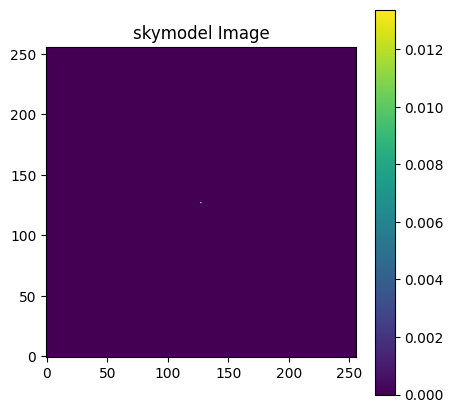

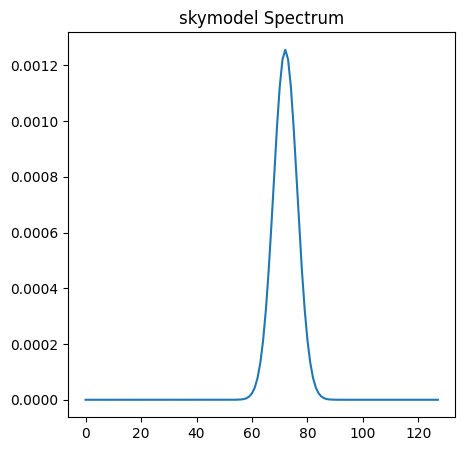

True brightness: 0.0012562683099855614
Total brightness: 0.013372562091084294
Min brightness: 0.0
Peak brightness: 0.0012562683099855614
Frequency resolution: 250.0 MHz



0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%
2024-03-27 17:04:41	WARN	simobserve::noise::casa	observing freqency is lower than expected for ALMA
2024-03-27 17:04:41	WARN	simobserve::noise::casa	proceeding with extrapolated receiver temp=28
....10....20....30....40....50....60....70....80....90....100%


Adding Atmospheric Noise using a scale factor of 0.5 for thropospheric phase



0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%
2024-03-27 17:09:01	WARN	task_tclean::SIImageStore::restore (file /source/casa6/casatools/src/code/synthesis/ImagerObjects/SIImageStore.cc, line 2265)	Restoring with an empty model image. Only residuals will be processed to form the output restored image.


Saving Dirty and Clean Cubes
Sky total flux: 0.013372562091084294
Dirty total flux: 642.49695
Sky peak flux: 0.0012562683099855614
Dirty peak flux: 0.0011095719


TypeError: type Quantity doesn't define __round__ method

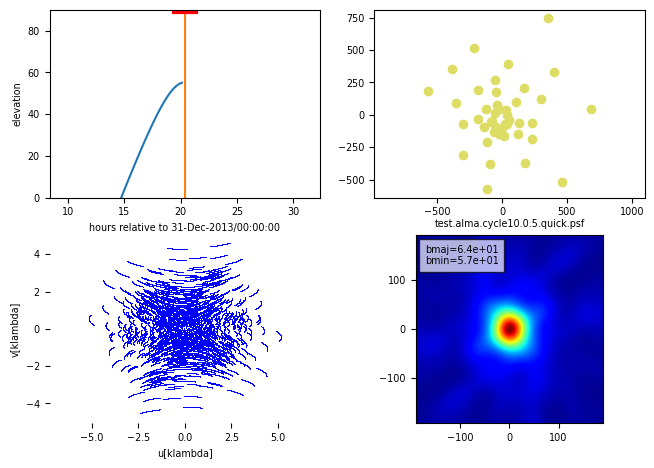

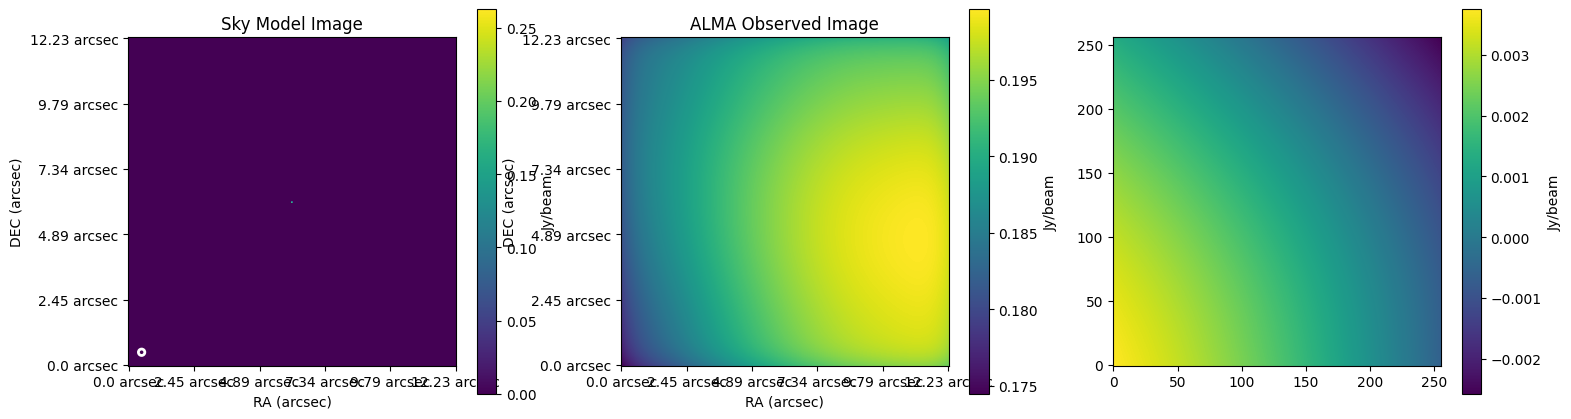

In [33]:
idx = 0
output_dir = current_path
plot_dir = current_path
project = 'test'
if not os.path.exists(os.path.join(output_dir, project)):
    os.mkdir(os.path.join(output_dir, project))
source_name = source_names[idx]
print(source_name)
ra = ras[idx]
dec = decs[idx]
band = bands[idx]
ang_res = ang_ress[idx]
vel_res = vel_ress[idx]
fov = fovs[idx]
obs_date = obs_dates[idx]
pwv = pwvs[idx]
int_time = int_times[idx]
total_time = total_times[idx]
bandwidth = bandwidths[idx]
freq = freqs[idx]
freq_support = freq_supports[idx]
spatial_resolution = spatial_resolutions[idx]
central_freq = sm.get_band_central_freq(int(band)) * U.GHz
source_freq = freq * U.GHz
#print('central_freq given band {}: '.format(band), central_freq)
rest_frequency = 115.271 * U.GHz
radio_equivalence = U.doppler_radio(rest_frequency)
central_velocity = central_freq.to(U.km / U.s, equivalencies=radio_equivalence)
source_velocity = source_freq.to(U.km / U.s, equivalencies=radio_equivalence)
#print('central_velocity:', central_velocity)
#print('source_velocity:', source_velocity)
band_range = sm.get_band_range(int(band))

fov = fov * U.deg
fov = fov.to(U.arcsec)
#print('FOV in arcsec:', fov)
def convert_range_from_GHz_to_km_s(central_freq, central_velocity, freq_range):
    freq_band = freq_range[1] - freq_range[0]
    freq_band = freq_band * U.GHz
    dv = (c * freq_band  / central_freq).to(U.km / U.s)
    return dv

vel_range = convert_range_from_GHz_to_km_s(central_freq, central_velocity, band_range)
#print('Velocity Range:', vel_range)
n_channels = int(vel_range.value / vel_res)
#print('n_channels:', n_channels)
n_px = int(fov.value / ang_res)
#print('n_px:', n_px)

antenna_config = sm.get_antenna_config_from_date(obs_date)
antenna_id, cycle = antenna_config
antenna_name = os.path.join('cycle{}'.format(int(cycle)), 'alma.cycle{}.0.{}'.format(int(cycle), int(antenna_id)))
print('antenna_name:', antenna_name)
antennalist = os.path.join(parent_dir, "antenna_config", antenna_name + '.cfg')
max_baseline = sm.get_max_baseline_from_antenna_config(antennalist) * U.km
print('max_baseline:', max_baseline)
antenna_name = os.path.split(antenna_name)[1]
config_number = int(antenna_name.split('.')[-1])
import math

def estimate_alma_beam_size(central_frequency_ghz, max_baseline_km):
  """
  Estimates the beam size of the Atacama Large Millimeter/submillimeter Array (ALMA) in arcseconds.

  This function provides an approximation based on the theoretical relationship between
  observing frequency and maximum baseline. The formula used is:
  beam_size = (speed_of_light / central_frequency) / max_baseline * (180 / pi) * 3600 arcseconds
  [km]/[s] * [s] / [km] = [radians] * [arcsec /radian] * [arcseconds/degree]

  Args:
      central_frequency_ghz: Central frequency of the observing band in GHz (float).
      max_baseline_km: Maximum baseline of the antenna array in kilometers (float).

  Returns:
      Estimated beam size in arcseconds (float).

  Raises:
      ValueError: If either input argument is non-positive.
  """

  # Input validation
  if central_frequency_ghz <= 0 or max_baseline_km <= 0:
    raise ValueError("Central frequency and maximum baseline must be positive values.")

  # Speed of light in meters per second
  speed_of_light = 299792458

  # Convert frequency to Hz
  central_frequency_hz = central_frequency_ghz.to(U.Hz).value

  # Convert baseline to meters
  max_baseline_meters = max_baseline_km.to(U.m).value

  # Theoretical estimate of beam size (radians)
  theta_radians = (speed_of_light / central_frequency_hz) / max_baseline_meters

  # Convert theta from radians to arcseconds
  beam_size_arcsec = theta_radians * (180 / math.pi) * 3600 * U.arcsec

  return beam_size_arcsec

beam_size = estimate_alma_beam_size(central_freq, max_baseline)
cell_size = beam_size / 5
fov = sm.get_fov_from_band(int(band))
n_px = 256
vel_res = vel_res * U.km / U.s
print('n_px:', n_px)
print('cell_size:', cell_size)
print('central_velocity:', central_velocity)
print('source_velocity:', source_velocity)
print('Velocity Range:', vel_range)

# Calculate the number of channels (including the very edge channels)
#num_channels = int(vel_range.value / vel_res.value) + 1
num_channels = 128
vel_res = vel_range / (num_channels - 1)
# Calculate the central channel index (assuming zero-based indexing)
central_channel_index = num_channels // 2
source_channel_index = int(central_channel_index * source_velocity / central_velocity)
print(f"Number of channels: {num_channels}")
print(f"Central velocity channel: {num_channels // 2}")
print(f"Source velocity channel: {source_channel_index}")
print(f"Velocity resolution: {vel_res}")
datacube = sm.DataCube(
  n_px_x=n_px, 
  n_px_y=n_px,
  n_channels=num_channels, 
  px_size=cell_size, 
  channel_width=vel_res, 
  velocity_centre=central_velocity, 
  ra=ra * U.deg, 
  dec=dec * U.deg)
wcs = datacube.wcs
pos_x, pos_y, _ = wcs.sub(3).wcs_world2pix(ra, dec, central_velocity, 0)
pos_z = int(source_channel_index)
db = sm.sample_from_brightness(1, vel_res.value * 10, rest_frequency.value, os.path.join(parent_dir, 'brightnes', 'CO10.dat'))
brightness = db['Brightness(Jy)'].values[0]
z = db['Redshift'].values[0]
print('brightness:', brightness)
print('z:', z)
fwhm_z = 10

def insert_pointlike(datacube, amplitude, pos_x, pos_y, pos_z, fwhm_z, n_px, n_chan):
    z_idxs = np.arange(0, n_chan)
    g = sm.gaussian(z_idxs, 1, pos_z, fwhm_z)
    import scipy.integrate as integrate
    #integral = integrate.quad(lambda x: sm.gaussian(x, 1, pos_z, fwhm_z), min(z_idxs), max(z_idxs))
    #g /= integral[0]
    ts = np.zeros((n_px, n_px, n_chan))
    ts[int(pos_x), int(pos_y), :] = amplitude
    for z in range(datacube._array.shape[2]):
        slice_ = g[z] * ts[:, :, z]
        datacube._array[:, :, z] += slice_ * U.Jy * U.pix**-2
    return datacube

datacube = insert_pointlike(datacube, brightness, pos_x, pos_y, pos_z, fwhm_z, n_px, num_channels)
filename = os.path.join(output_dir, project, 'skymodel_{}.fits'.format(idx))
sm.write_datacube_to_fits(datacube, filename)
sm.plot_skymodel(filename, idx, plot_dir, show=True)
skymodel, sky_header = sm.load_fits(filename)
true_brightness = np.max(skymodel)
total_brightness = np.sum(skymodel)
min_brightness = np.min(skymodel)
print('True brightness:', true_brightness)
print('Total brightness:', total_brightness)
print('Min brightness:', min_brightness)
peak_brightness = np.max(skymodel)
print('Peak brightness:', peak_brightness)
freq_res = (band_range[1] - band_range[0]) / 128 * U.GHz
print('Frequency resolution:', freq_res.to(U.MHz))
simobserve(
    project=project, 
    skymodel=filename,
    obsmode="int",
    antennalist=antennalist,
    )
scale = 0.5
print('Adding Atmospheric Noise using a scale factor of {} for thropospheric phase'.format(scale))
    # scale is a multiplicative factor for the thropospheric phase 
    # which is a delay in the propagation of radio waves in the atmosphere
    # caused by the refractive index of the throphosphere
#sm.simulate_atmospheric_noise(
#    os.path.join(output_dir, project), 
#    scale, 
#    os.path.join(output_dir, project, "{}.{}.noisy.ms".format(project, antenna_name)), 
#    antennalist)
#gain_error_amplitude = random.gauss(0.001, 0.1)
#sm.simulate_gain_errors(
#    os.path.join(output_dir, project, "{}.{}.noisy.ms".format(project, antenna_name)),
#    gain_error_amplitude
#)
tclean(
    vis=os.path.join(project, "{}.{}.noisy.ms".format(project, antenna_name)),
    imagename=os.path.join(project, '{}.{}'.format(project, antenna_name)),
    imsize=[int(n_px), int(n_px)],
    cell="{}".format(cell_size),
    specmode="cube",
    niter=0,
    fastnoise=False,
    calcpsf=True,
    pbcor=True,
    pblimit=0.2,
    )

print('Saving Dirty and Clean Cubes')
exportfits(imagename=os.path.join(project, '{}.{}.image'.format(project, antenna_name)), 
       fitsimage=os.path.join(output_dir, "dirty_cube_" + str(idx) +".fits"), overwrite=True)
exportfits(imagename=os.path.join(project, '{}.{}.skymodel'.format(project, antenna_name)), 
        fitsimage=os.path.join(output_dir, "clean_cube_" + str(idx) +".fits"), overwrite=True)
clean, clean_header = sm.load_fits(os.path.join(output_dir, "clean_cube_" + str(idx) +".fits"))
dirty, dirty_header = sm.load_fits(os.path.join(output_dir, "dirty_cube_" + str(idx) +".fits"))
sky_total_flux = np.nansum(skymodel)
dirty_total_flux = np.nansum(dirty)
sky_peak_flux = np.nanmax(skymodel)
dirty_peak_flux = np.nanmax(dirty)
print('Sky total flux:', sky_total_flux)
print('Dirty total flux:', dirty_total_flux)
print('Sky peak flux:', sky_peak_flux)
print('Dirty peak flux:', dirty_peak_flux)

run_tclean = False
sm.plotter(idx, output_dir, plot_dir, run_tclean, band, cycle, peak_brightness, beam_size, cell_size, antenna_name, fwhm_z, show=True)
shutil.rmtree(project)

os.remove(filename)
os.remove(os.path.join(output_dir, "dirty_cube_" + str(idx) +".fits"))
os.remove(os.path.join(output_dir, "clean_cube_" + str(idx) +".fits"))
print('Done')




In [ ]:
idx = 1

obs_date = obs_dates[idx]
antenna_name = antenna_names[idx]
band = int(bands[idx])
ra = ras[idx]
dec = decs[idx]
n_px = n_pxs[idx]
n_channel = n_channels[idx]
integration = int_times[idx]
total_time = total_times[idx]
pwv = pwvs[idx]
cycle = os.path.split(antenna_name)[0]
antenna_name = os.path.split(antenna_name)[1]
config_number = int(antenna_name.split('.')[-1])
# This function takes the spatial resolution 
spatial_resolution = sm.get_spatial_resolution(band, config_number)
central_freq = sm.get_band_central_freq(band)
# From the antenna configuration file, we get the maximum baseline, which is used to compute the beam size, and then cell_size
antennalist = os.path.join(parent_dir, "antenna_config", cycle, antenna_name + '.cfg')
max_baseline = sm.get_max_baseline_from_antenna_config(antennalist)
beam_size = sm.compute_beam_size_from_max_baseline(max_baseline, central_freq)
cell_size = beam_size / 5
# FoV only depends from the band (central frequency)
fov = sm.get_fov([band])[0]
print('Computed spatial resolution for band {} config {} and date {} is {} with respect to recorded {}'.format(band, config_number, obs_date, spatial_resolution, round(ang_res[idx], 2)))
print('Beam size:', beam_size)
print('Cell size:', cell_size)
print('Computed FoV from band {} is {} with respect to recorded {}'.format(band, round(fov, 2), round(fovs[idx], 2)))
print('Integration time:', integration)
print('Total time:', total_time)
print('\n')
#3683 of simulator function
n_sources = 4
bandwidth = 1280
inwidth = 10
serendipitous = True
run_tclean = False
fwhm_x = 1.5 * cell_size * np.random.rand() + cell_size
fwhm_y = 1.5 * cell_size  * np.random.rand() + cell_size
fwhm_z = 0.1 * bandwidth * np.random.rand() + inwidth
pa = np.random.randint(0, 360)
min_sep_spatial = 1.5 * cell_size
min_sep_frequency = 1.5 * inwidth
inbright = 0.001
filename = sm.generate_gaussian_skymodel(idx, current_path, n_sources,
                                                  n_px, n_channel, bandwidth, 
                                                  fwhm_x * U.arcsec, fwhm_y * U.arcsec, 
                                                  fwhm_z * U.MHz,
                                                  cell_size * U.arcsec,  
                                                  fov * U.arcsec, 
                                                  cell_size * U.arcsec, 
                                                  central_freq * U.GHz,
                                                  inwidth * U.GHz,
                                                  ra * U.deg, dec * U.deg,
                                                  pa, 
                                                  min_sep_spatial, 
                                                  min_sep_frequency,
                                                  rest_frequency, 
                                                  serendipitous,
                                                  current_path)

skymodel, sky_header = sm.load_fits(filename)
true_brightness = np.max(skymodel)
min_brightness = np.min(skymodel)
print('True Brightness', true_brightness, ' Jy/px')
print('Minimum Brightness', min_brightness, ' Jy/px')
if inbright != true_brightness:
    print('Adjusting Brightness')
    flattened_skymodel = np.ravel(skymodel)
    t_min = 0
    t_max = inbright
    skymodel_norm = (flattened_skymodel - np.min(flattened_skymodel)) / (np.max(flattened_skymodel) - np.min(flattened_skymodel)) * (t_max - t_min) + t_min
    skymodel = np.reshape(skymodel_norm, np.shape(skymodel))
    print('New Brightness', np.max(skymodel), ' Jy/px')
    sm.write_numpy_to_fits(skymodel, sky_header, filename)
simobserve(
    project=project, 
    skymodel=filename,
    inbright="{}Jy/pix".format(inbright),
    incell="{}arcsec".format(cell_size),
    indirection="J2000 19h30m00 -40d00m00",
    incenter='{}GHz'.format(central_freq),
    inwidth="{}MHz".format(inwidth),
    setpointings=True,
    integration="{}s".format(integration),
    obsmode="int",
    antennalist=antennalist,
    totaltime="{}s".format(total_time),
    thermalnoise="tsys-atm",
    user_pwv=pwv,
    graphics="none",
    verbose=False,
    overwrite=True)

# Adding atmosphere noise
#scale = random.uniform(0.3, 1)
scale = 0.5
print('Adding Atmospheric Noise using a scale factor of {} for thropospheric phase'.format(scale))
# scale is a multiplicative factor for the thropospheric phase 
# which is a delay in the propagation of radio waves in the atmosphere
# caused by the refractive index of the throphosphere
sm.simulate_atmospheric_noise(
    os.path.join(output_dir, project), 
    scale, 
    os.path.join(output_dir, project, "{}.{}.noisy.ms".format(project, antenna_name)), 
    antennalist)
gain_error_amplitude = random.gauss(0.001, 0.1)
sm.simulate_gain_errors(
    os.path.join(output_dir, project, "{}.{}.noisy.ms".format(project, antenna_name)),
    gain_error_amplitude
)

tclean(
    vis=os.path.join(project, "{}.{}.noisy.ms".format(project, antenna_name)),
    imagename=os.path.join(project, '{}.{}'.format(project, antenna_name)),
    imsize=[int(n_px), int(n_px)],
    cell="{}arcsec".format(cell_size),
    specmode="cube",
    niter=0,
    fastnoise=False,
    calcpsf=True,
    pbcor=True,
    pblimit=0.2,
    )

print('Saving Dirty and Clean Cubes')
exportfits(imagename=os.path.join(project, '{}.{}.image'.format(project, antenna_name)), 
       fitsimage=os.path.join(output_dir, "dirty_cube_" + str(idx) +".fits"), overwrite=True)
exportfits(imagename=os.path.join(project, '{}.{}.skymodel'.format(project, antenna_name)), 
        fitsimage=os.path.join(output_dir, "clean_cube_" + str(idx) +".fits"), overwrite=True)
sm.plotter(idx, output_dir, plot_dir, run_tclean, band, cycle, inbright, beam_size, cell_size, antenna_name, fwhm_z, show=True)
shutil.rmtree(project)
os.remove(filename)
os.remove(os.path.join(output_dir, "dirty_cube_" + str(idx) +".fits"))
os.remove(os.path.join(output_dir, "clean_cube_" + str(idx) +".fits"))
print('Done')